In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # statistical data visualization
# use '%matplotlib inline' if ipympl is not installed
%matplotlib ipympl
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# my code:
import regular_oncompare
import federated_oncompare

# regular onCompare

In [2]:
original_pvals=[] # with sklearn logistic regression
new_pvals= [] # with gradient descent code
scale=True

In [3]:
# all data
mutation_status_negatives, mutation_status_positives, covariates_negatives, covariates_positives = regular_oncompare.getData("all_data.csv")
# get probs
probs1, probs2 = regular_oncompare.get_probs(mutation_status_negatives, mutation_status_positives, covariates_negatives, covariates_positives, scale)
# get observation counts
observed1 = np.sum(mutation_status_negatives.loc[probs1.index].values > 0) #.sum(axis=1)
observed2 = np.sum(mutation_status_positives.loc[probs2.index].values > 0) #.sum(axis=1)
# get pval
pval = regular_oncompare.getPVal(observed1, observed2, probs1, probs2)

model weights: [[-1.65694154e-03 -5.09480333e-03  9.88795379e+00]], [-11.89030793]
pval is 1.0


In [4]:
original_pvals.append(pval)
# same with my model (gradient descent)
probs1, probs2 = regular_oncompare.get_probs(mutation_status_negatives, mutation_status_positives, covariates_negatives, covariates_positives, scale, mymodel=True)
new_pvals.append(regular_oncompare.getPVal(observed1, observed2, probs1, probs2))

pval is 0.2309915507287274
converged after 285 iterations
Final Coefficients: [-1.68838449] & [-0.00283963  0.24445207]
pval is 0.009185575173997831


In [6]:
for hospital in range(1, 6):
    print(f"----------- hospital {hospital} -----------")
    mutation_status_negatives, mutation_status_positives, covariates_negatives, covariates_positives = \
        regular_oncompare.getData("data_hospital" + str(hospital) + ".csv")
    probs1, probs2 = regular_oncompare.get_probs(mutation_status_negatives, mutation_status_positives, covariates_negatives, covariates_positives, scale)
    observed1 = np.sum(mutation_status_negatives.loc[probs1.index].values > 0) #.sum(axis=1)
    observed2 = np.sum(mutation_status_positives.loc[probs2.index].values > 0) #.sum(axis=1)
    original_pvals.append(regular_oncompare.getPVal(observed1, observed2, probs1, probs2))
    probs1, probs2 = regular_oncompare.get_probs(mutation_status_negatives, mutation_status_positives, covariates_negatives, covariates_positives, scale, mymodel=True)
    new_pvals.append(regular_oncompare.getPVal(observed1, observed2, probs1, probs2))

----------- hospital 1 -----------
pval is 0.8706885201408108
converged after 314 iterations
Final Coefficients: [-1.9477393] & [0.14276328 0.06938584]
pval is 0.6342200115982326
----------- hospital 2 -----------
pval is 0.6532799517284261
converged after 316 iterations
Final Coefficients: [-1.84022951] & [0.49419333 0.33511425]
pval is 0.21405798119083194
----------- hospital 3 -----------
pval is 0.6745928702409524
converged after 274 iterations
Final Coefficients: [-1.53605323] & [0.05357124 0.36313638]
pval is 0.24483366508002952
----------- hospital 4 -----------
pval is 0.28707441889601515
converged after 268 iterations
Final Coefficients: [-1.56667456] & [-0.04865631  0.08229003]
pval is 0.14433879516491033
----------- hospital 5 -----------
pval is 0.6474381935570985
converged after 287 iterations
Final Coefficients: [-1.67852779] & [-0.06985775  0.29257729]
pval is 0.26437516623577373


In [7]:
original_pvals
new_pvals

[0.2309915507287274,
 0.8706885201408108,
 0.6532799517284261,
 0.6745928702409524,
 0.28707441889601515,
 0.6474381935570985]

[0.009185575173997831,
 0.6342200115982326,
 0.21405798119083194,
 0.24483366508002952,
 0.14433879516491033,
 0.26437516623577373]

# federated onCompare
## data that needs to be aggregated/distributed between hospitals:
- total number of samples in total
- total number of observations per group (pos/neg)
- several other aggregated data (sum, squared x-mean sum, etc) for rescaling
            needed to scale all data uniformly, else all data is scaled on a different mean/stddev of the TMB (tumor burden)
            improves performance significantly
- loss, dW, db summed

In [8]:
# federated data
# init hospitals, not needed in real setting scenario
hospitals = []
for i in range(0, 5):
    hospitals.append(federated_oncompare.federatedHospitalWithSecurityLayer("data_hospital" + str(i+1) + ".csv")) 

In [9]:
fedLogReg = federated_oncompare.FederatedLogisticRegression(hospitals, scale)
probs1, probs2 = fedLogReg.get_probs(hospitals)
observed1, observed2 = fedLogReg.get_observation_counts(hospitals)
pval = regular_oncompare.getPVal(observed1, observed2, probs1, probs2)
new_pvals.append(pval)
original_pvals.append(0) # dummy

converged after 277 iterations
Final Coefficients: [-1.66086864] & [-0.00942583]
pval is 3.74245323051204e-05


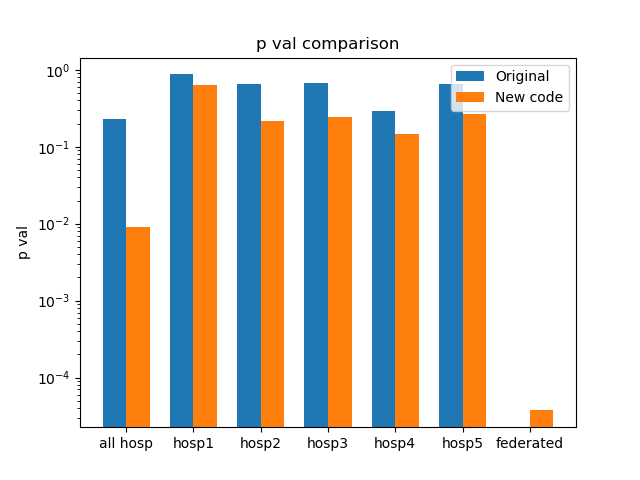

In [11]:
InteractiveShell.ast_node_interactivity = "last_expr"
x = np.arange(len(new_pvals))
width = 0.35
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, original_pvals, width, label='Original')
rects2 = ax.bar(x + width/2, new_pvals, width, label='New code')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('p val')
ax.set_title('p val comparison')
ax.set_xticks(x)
ax.set_xticklabels(('all hosp', 'hosp1', 'hosp2', 'hosp3', 'hosp4', 'hosp5', 'federated'))
ax.legend()

plt.yscale('log')
plt.show()

## how to proceed?
- need for validation?
- homomorhpic encryption?
- differential privacy preserving
- which federated model to use? 
    - flwr/feder8? different model or create our own (RPC?) i.e. with homomorhpic encryption support 
    - eventbus (socket)
    

### flwr
- stop iterations at convergence? -> extenden van server/strategy 
- workflow -> start server/clients at given intervals vs always running server/clients
